<a href="https://colab.research.google.com/github/Reema-Almadhi/heart-disease-prediction/blob/main/Heart_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import seaborn
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Loading the Data

# update path below to your own path
df = pd.read_csv('/content/drive/MyDrive/Heart-disease/heart.csv')

# Rename target column to match original code usage
df = df.rename(columns={'target': 'disease_present'})

df.head()



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease_present
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


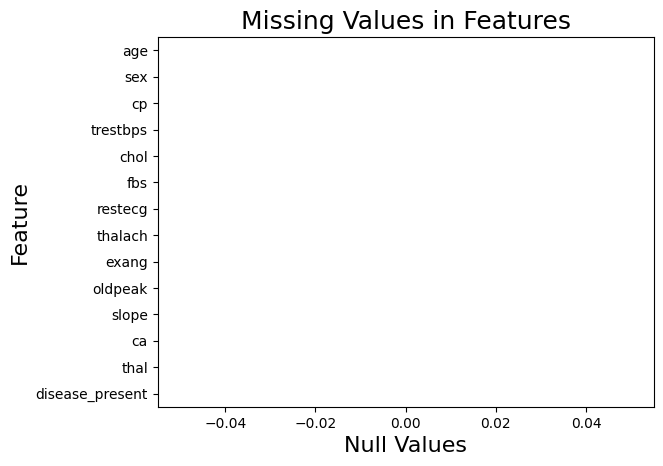

In [8]:
# Missing Value Treatment

# Counting null values in each feature
df_null = pd.DataFrame(df.isnull().sum().reset_index())
df_null.columns = ['feature', 'null_values']
df_null

# Barchart for null values
sns.barplot(y=df_null['feature'], x=df_null['null_values'], orient='h')
plt.title('Missing Values in Features', fontsize=18)
plt.xlabel('Null Values', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.show()


In [9]:
# For Categorical features, replacing null values using backfill method
df = df.sample(frac=1, random_state=0)
for cat_col in ['restecg', 'fbs', 'exang', 'slope', 'thal']:
    if cat_col in df.columns:
        df[cat_col].fillna(method='bfill', inplace=True)


/tmp/ipython-input-247/4202904127.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[cat_col].fillna(method='bfill', inplace=True)
/tmp/ipython-input-247/4202904127.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[cat_col].fillna(method='bfill', inplace=True)


In [10]:
# For Numerical features, replacing null values with mean of the feature
for num_col in ['thalach', 'oldpeak', 'trestbps', 'chol', 'ca']:
    if num_col in df.columns:
        df[num_col].fillna(df[num_col].mean(), inplace=True)

df.isnull().sum()

/tmp/ipython-input-247/1096856204.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[num_col].fillna(df[num_col].mean(), inplace=True)


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


**Visuals**

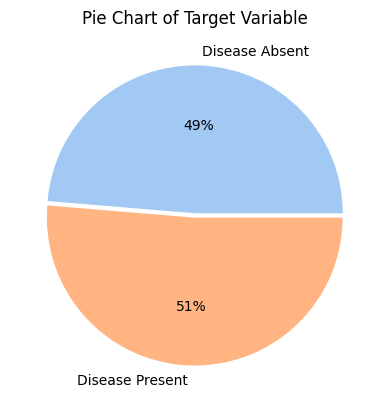

In [11]:

# Pie-chart of Target feature

unique_values = df['disease_present'].unique()
counts = df['disease_present'].value_counts().sort_values()
percentages = counts / counts.sum() * 100
plt.pie(percentages, labels=['Disease Absent', 'Disease Present'],
        colors=sns.color_palette('pastel'), explode=[0.02,0.01], autopct='%.0f%%')
plt.title('Pie Chart of Target Variable')
plt.show()

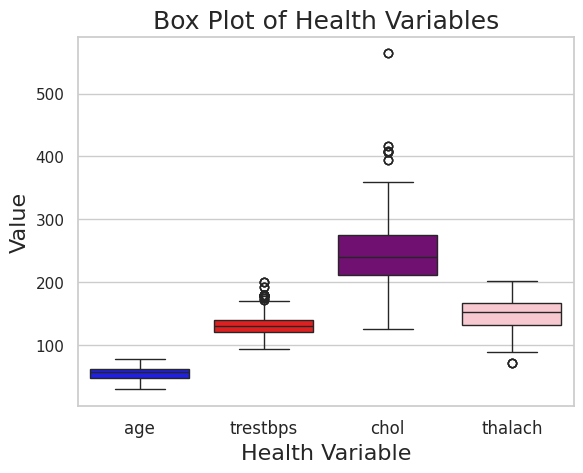

In [12]:
# Box Plot of Health Variables

health_variables = ['age', 'trestbps', 'chol', 'thalach']
colors = ['blue', 'red', 'purple', 'pink']
sns.set(style="whitegrid")
ax = sns.boxplot(data=df[health_variables], palette=colors)
ax.set_xticks(range(len(health_variables)))
ax.set_xticklabels(health_variables, fontsize=12)
ax.set_xlabel('Health Variable', fontsize=16)
ax.set_ylabel('Value', fontsize=16)
ax.set_title('Box Plot of Health Variables', fontsize=18)
plt.show()

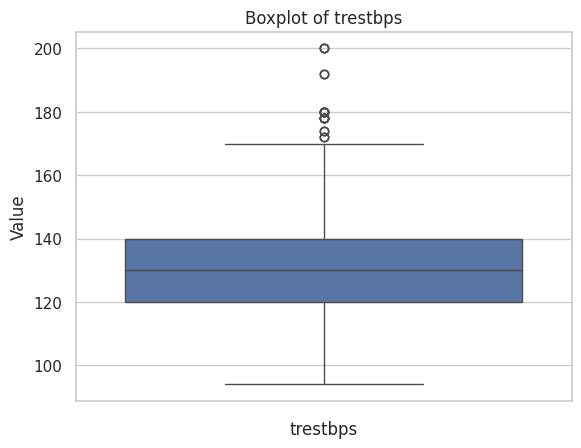

In [13]:
# Boxplot for any numerical feature
numerical_features = ['age', 'trestbps', 'chol', 'fbs', 'exang', 'oldpeak', 'thalach']
feature = 'trestbps'
sns.boxplot(y=df[feature])
plt.xlabel(feature)
plt.ylabel('Value')
plt.title(f'Boxplot of {feature}')
plt.show()

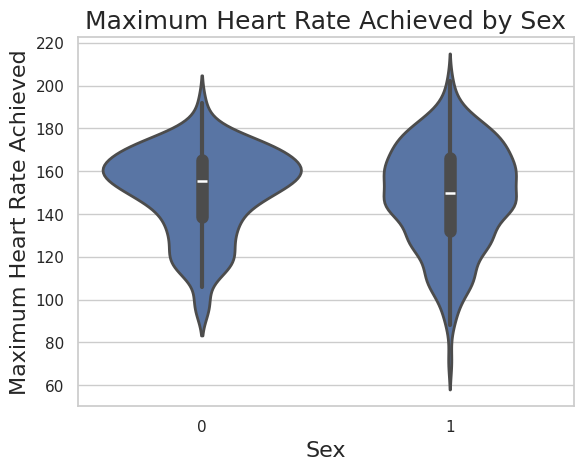

In [14]:
# Violin Plot of Maximum Heart Rate Achieved

sns.set(style="whitegrid")
ax = sns.violinplot(x=df["sex"], y=df["thalach"], linewidth=2)
ax.set_xlabel('Sex', fontsize=16)
ax.set_ylabel('Maximum Heart Rate Achieved', fontsize=16)
ax.set_title('Maximum Heart Rate Achieved by Sex', fontsize=18)
plt.show()

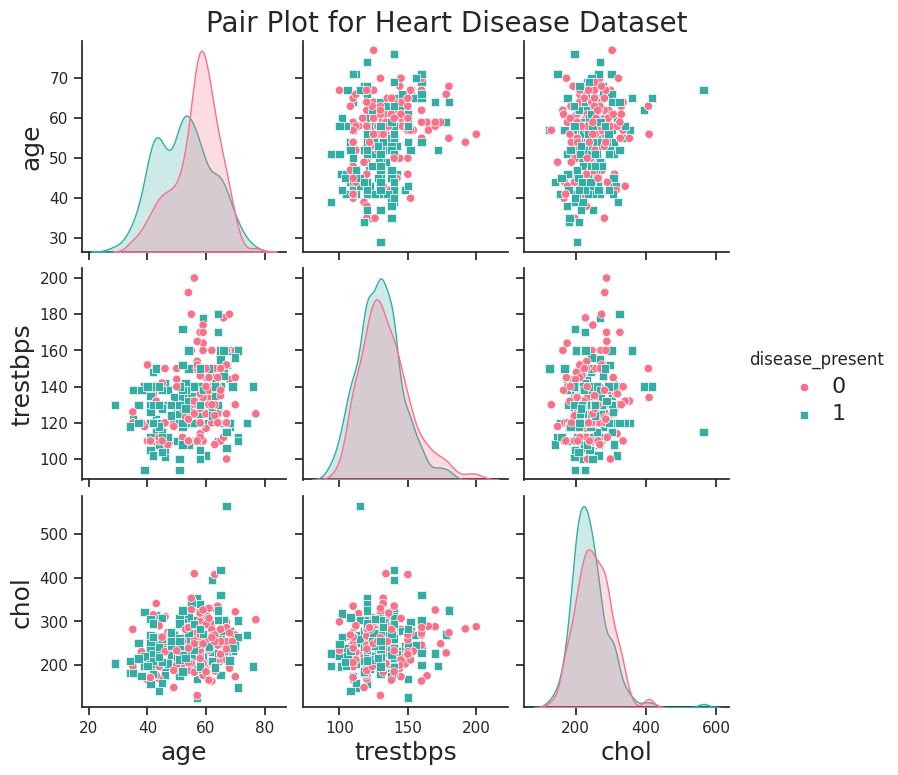

In [15]:
# Pair Plot

selected_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'disease_present']
df_subset = df[selected_columns].copy()

# Convert categorical variables
df_subset['sex'] = df_subset['sex'].astype('category')
df_subset['cp'] = df_subset['cp'].astype('category')
df_subset['disease_present'] = df_subset['disease_present'].astype('category')

sns.set(style="ticks", color_codes=True)
pair_plot = sns.pairplot(df_subset, hue='disease_present', palette='husl', markers=["o", "s"])
pair_plot.fig.suptitle("Pair Plot for Heart Disease Dataset", y=1.02, fontsize=20)

legend = pair_plot._legend
for text in legend.get_texts():
    text.set_fontsize(16)

for ax in pair_plot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)
plt.show()



In [16]:
# Data Transformation for Modeling

label_encoder = LabelEncoder()
for col in ['cp', 'restecg', 'slope', 'thal', 'fbs', 'exang']:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col])

# 'sex' is already numeric (0/1), so keep as-is
df.to_csv('/content/drive/MyDrive/final_data.csv', index=False)


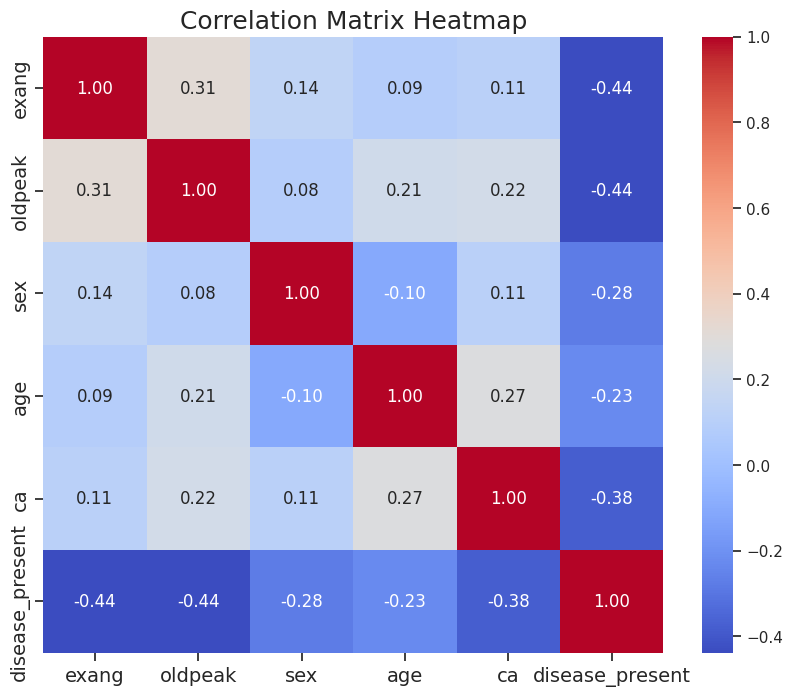

In [29]:
# Correlation Matrix Heatmap
features_analysis=['exang', 'oldpeak', 'sex', 'age', 'ca', 'disease_present']
#features_analysis=['age', 'sex', 'trestbps', 'oldpeak', 'disease_present']
#features_analysis = df.columns
for i in features_analysis:
    df[i] = pd.to_numeric(df[i], errors='coerce')

subset_data = df[features_analysis]

correlation_matrix = subset_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Classification Models**

In [18]:
# Scaling the data using standard scaler

df = pd.read_csv('/content/drive/MyDrive/final_data.csv')

X = df.iloc[:, :-1].values # features
y = df.iloc[:, -1].values # variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) #80/20 split

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)




Classification Report:	 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       102
           1       0.97      0.92      0.95       103

    accuracy                           0.95       205
   macro avg       0.95      0.95      0.95       205
weighted avg       0.95      0.95      0.95       205

Metrics for Test Set:
Accuracy: 0.9463414634146341


Text(91.25, 0.5, 'Predicted')

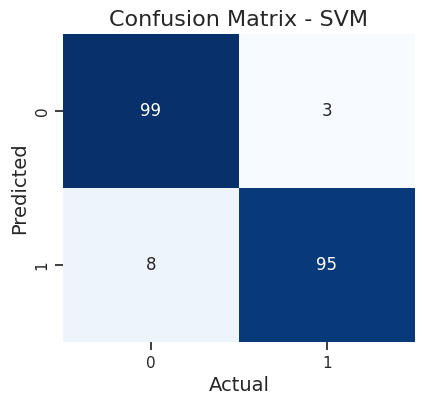

In [32]:
# Support Vector Machine (SVM)

classifier = SVC(kernel='rbf')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred)
print("\nClassification Report:\t ")
print(classification_report(y_test, y_pred))

precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

print('Metrics for Test Set:')
print('Accuracy: {}'.format((cm_test[0][0] + cm_test[1][1]) / len(y_test)))

# Plot Confusion Matrices
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM', fontsize = 16)
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Predicted', fontsize = 14)


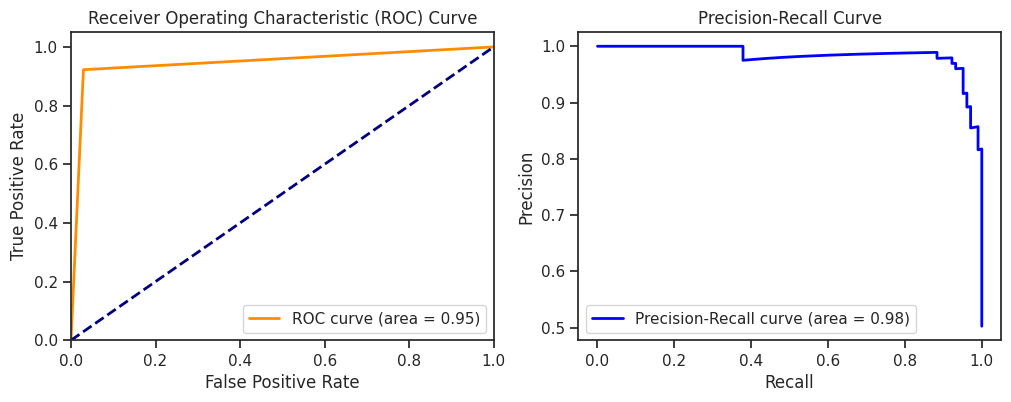

In [20]:
# ROC Curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve of test set
precision, recall, thresholds = precision_recall_curve(y_test, classifier.decision_function(X_test))
area_under_curve = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = {:.2f})'.format(area_under_curve))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


Accuracy for training set for Logistic Regression = 85.61%
Accuracy for test set for Logistic Regression = 84.39%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       102
           1       0.83      0.86      0.85       103

    accuracy                           0.84       205
   macro avg       0.84      0.84      0.84       205
weighted avg       0.84      0.84      0.84       205



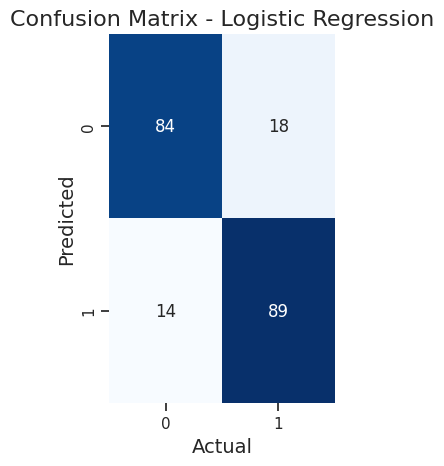

In [36]:
# Logistic Regression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# predictions(Test Set)
y_pred = classifier.predict(X_test)

# confusion matrix(Test Set)
cm_test = confusion_matrix(y_test, y_pred)

# predictions(Training Set)
y_pred_train = classifier.predict(X_train)

# confusion matrix(Training Set)
cm_train = confusion_matrix(y_pred_train, y_train)

# print the accuracy
print('Accuracy for training set for Logistic Regression = {:.2%}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Logistic Regression = {:.2%}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix visualization
#plt.figure(figsize=(12, 4))
#plt.subplot(1, 2, 1)
#plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Logistic Regression', fontsize = 16)
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Predicted', fontsize = 14)

# cross-validation
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)
#print("\nCross-Validation Scores:", cv_scores)
#print("Mean CV Accuracy: {:.2%}".format(cv_scores.mean()))


Accuracy for test set for XGBoost = 0.9853658536585366

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       102
           1       0.97      1.00      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



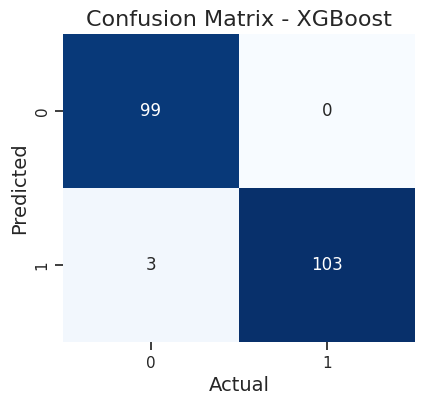

In [22]:
# XGBoost

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


xg = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=3,
    subsample=0.85,
    colsample_bytree=0.75,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=1,
    eval_metric='logloss'
)

xg.fit(X_train, y_train)

y_pred = xg.predict(X_test)

cm_test = confusion_matrix(y_pred, y_test)

TP = cm_test[1, 1]  # True Positives
FP = cm_test[0, 1]  # False Positives
TN = cm_test[0, 0]  # True Negatives
FN = cm_test[1, 0]  # False Negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("Accuracy for test set for XGBoost =", (TN + TP)/len(y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

y_pred_train = xg.predict(X_train)

for i in range(0, len(y_pred_train)):
    if y_pred_train[i] >= 0.5:       # setting threshold to .5
        y_pred_train[i] = 1
    else:
        y_pred_train[i] = 0

# Confusion Matrix Plot for Test & Training set
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost', fontsize=16)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)

plt.show()

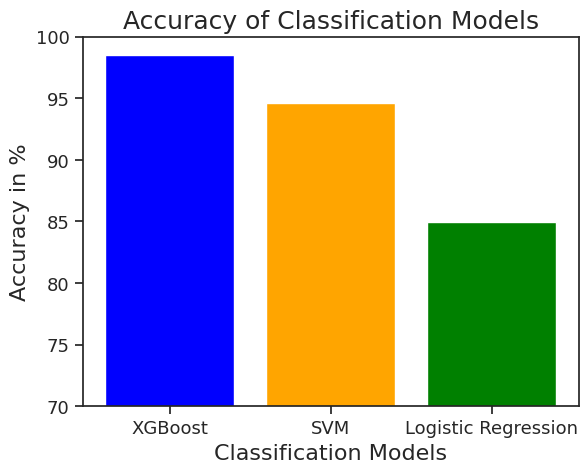

In [26]:
# Visualizations comparing Classification Models

# Accuracy scores of three models
models = ['XGBoost', 'SVM', 'Logistic Regression']
accuracy = [98.54, 94.63, 84.39 ]  # from model results

#plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['blue', 'orange', 'green'])

# Adding labels and title
plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Accuracy in %', fontsize=16)
plt.title('Accuracy of Classification Models', fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show the plot
plt.ylim(70, 100)  # Set the y-axis limits
plt.show()


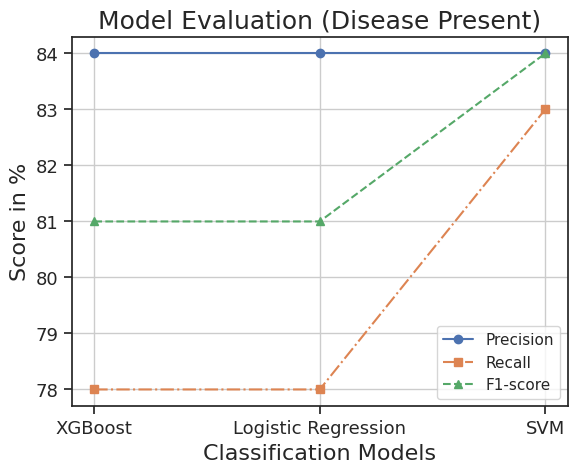

In [38]:
# Line chart to compare precision, recall and f1-score of classifiers (Class 1, Disease present)

# Precision, recall, and F1-scores of three models
models = ['XGBoost', 'Logistic Regression', 'SVM']
precision = [84, 84, 84]
recall = [78, 78, 83]
f1_scores = [81, 81, 84]

# Create line chart for precision
#plt.figure(figsize=(8, 6))
plt.plot(models, precision, marker='o', label='Precision', linestyle='-')

# Add line chart for recall
plt.plot(models, recall, marker='s', label='Recall', linestyle='-.')

# Add line chart for F1-score
plt.plot(models, f1_scores, marker='^', label='F1-score', linestyle='--')

# Adding labels and title
plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Score in %', fontsize=16)
plt.title('Model Evaluation (Disease Present)', fontsize=18)
plt.legend()  # Show legend
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show the plot
#plt.ylim(0, 1)  # Set the y-axis limits
plt.grid(True)  # Add gridlines
plt.show()


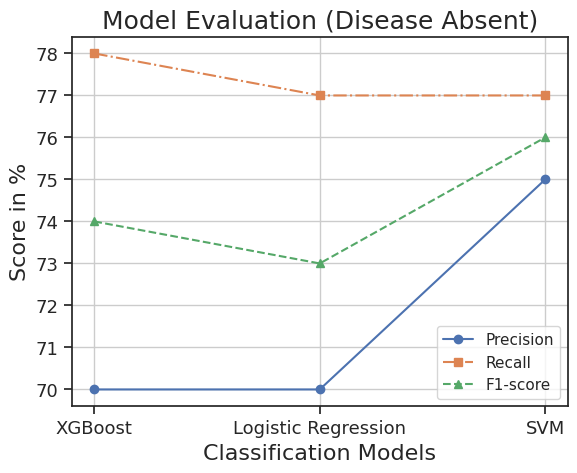

In [25]:
# Line chart to compare precision, recall and f1-score of classifiers (Class 0, Disease absent)

# Precision, recall, and F1-scores of three models
models = ['XGBoost', 'Logistic Regression', 'SVM']
precision = [70, 70, 75]
recall = [78, 77, 77]
f1_scores = [74, 73, 76]

# Create line chart for precision
#plt.figure(figsize=(8, 6))
plt.plot(models, precision, marker='o', label='Precision', linestyle='-')

# Add line chart for recall
plt.plot(models, recall, marker='s', label='Recall', linestyle='-.')

# Add line chart for F1-score
plt.plot(models, f1_scores, marker='^', label='F1-score', linestyle='--')

# Adding labels and title
plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Score in %', fontsize=16)
plt.title('Model Evaluation (Disease Absent)', fontsize=18)
plt.legend()  # Show legend
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show the plot
#plt.ylim(0, 1)  # Set the y-axis limits
plt.grid(True)  # Add gridlines
plt.show()

